# <p style="text-align: center; color: #1E90FF; font-size: 30px;">Stroke Analysis and Prediction</p>

### Table of Contents
* [Dataset Description](#1)
* [Numerical Variables (Distribution & Correlations)](#2)
* [Categorical Variables (Distribution & Correlations)](#3)
* [Target Variable (Stroke)](#4)
* [Correlations Between Numerical Variables & Target](#5)
* [Correlations Between Categorical Variables & Target](#6)
* [Preprocessing](#7)
* [Model 1 - Logistic Regression](#8)
* [Model 2 - Decision Tree](#9)
* [Model 3 - Random Forest](#10)
* [Model 4 - XGBoost](#11)
* [Performance Comparison](#12)

In [4]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import pickle

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from sklearn.tree import plot_tree

pd.set_option('display.max_columns', None) 
RANDOM_STATE = 42

In [5]:
#Examine the first 5 row of the dataset.
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=1>Dataset Description</h1>
</div>

In [6]:
#Check the number of rows and columns/features of this dataset.
df.shape

(5110, 12)

In [7]:
#Examine the columns and the data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


-The "bmi" column cotains 201 null.

In [8]:
df.columns.tolist()

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

Attribute Information
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not


In [9]:
#Examine basic descriptive statistics of the dataset.
orginal_description = df.describe().iloc[:,1:-1]
orginal_description

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237
std,22.612647,0.296607,0.226063,45.283560,7.854067
min,0.080000,0.000000,0.000000,55.120000,10.300000
25%,25.000000,0.000000,0.000000,77.245000,23.500000
50%,45.000000,0.000000,0.000000,91.885000,28.100000
75%,61.000000,0.000000,0.000000,114.090000,33.100000
max,82.000000,1.000000,1.000000,271.740000,97.600000


In [10]:
#rename column "Residence_type" as "residence_type" to match the overall style.
df = df.rename(columns = {'Residence_type':'residence_type'})
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [11]:
#Remove the "id" column as it is unrelated to our analysis.
df = df.drop('id', axis=1)

In [12]:
#handle null values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [13]:
#Remove rows with null values. (3.9% of the dataset)
df.dropna(axis = 0, inplace = True)

In [14]:
#Make sure that the dataset contains no more null values as our first model is sensitive to null values.
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [15]:
#Check the rows and columns after removing null values.
df.shape

(4909, 11)

In [16]:
#check if there are any duplicate values
df.duplicated().sum()

0

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=2>Numerical Variables (Distribution & Correlations)</h1>
</div>


In [17]:
#There are 2 numerical columns.
numerical_columns = ['age','avg_glucose_level','bmi']

**Glucose Level:**

Fasting Blood Sugar (FBS) or Fasting Plasma Glucose (FPG):

Normal: Less than 100 mg/dL (5.6 mmol/L)\
Prediabetes (impaired fasting glucose): 100-125 mg/dL (5.6-6.9 mmol/L)\
Diabetes: 126 mg/dL (7.0 mmol/L) or higher on two separate tests

**Body Mass Index (BMI):**

Underweight: BMI less than 18.5\
Normal weight: BMI 18.5 to 24.9\
Overweight: BMI 25 to 29.9\
Obesity (Class I): BMI 30 to 34.9\
Obesity (Class II): BMI 35 to 39.9\
Obesity (Class III): BMI 40 or higher

In [18]:
#basic stats of numeric features
df[numerical_columns].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,age,avg_glucose_level,bmi
count,4909.000000,4909.000000,4909.000000
mean,42.865374,105.305150,28.893237
std,22.555115,44.424341,7.854067
min,0.080000,55.120000,10.300000
10%,10.000000,65.626000,19.700000
25%,25.000000,77.070000,23.500000
50%,44.000000,91.680000,28.100000
75%,60.000000,113.570000,33.100000
90%,74.000000,187.004000,38.900000
max,82.000000,271.740000,97.600000


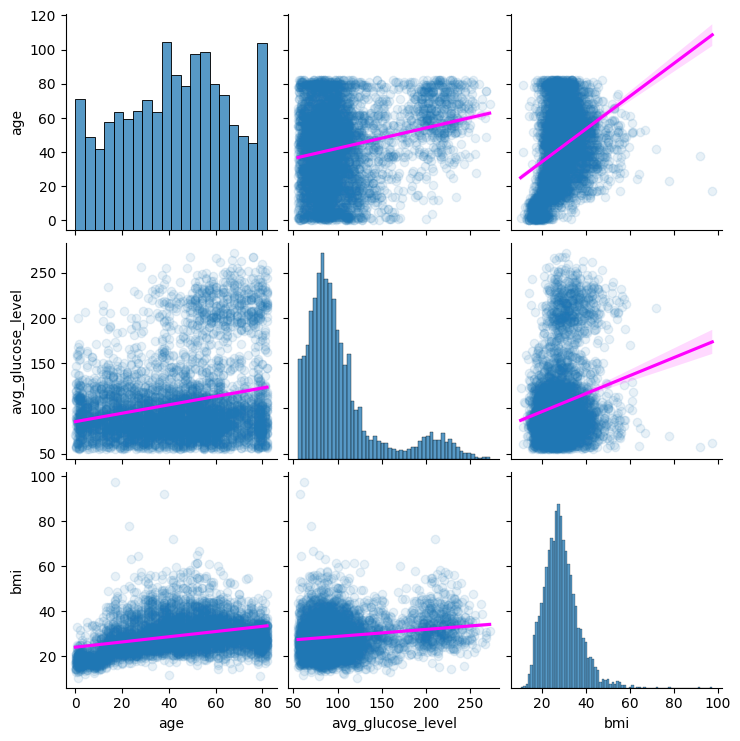

In [19]:
#Use a pairwise scatterplot to examine the distribution of each variable and the relationships between variables
sns.pairplot(df[numerical_columns], 
             kind = 'reg', 
             plot_kws = {'line_kws':{'color':'magenta'},
             'scatter_kws':{'alpha': 0.1}})
plt.show()

<b><u>Distribution</u></b><br>
**Age:** The distribution of age in this dataset is somewhat uniform but has noticeable peaks. The most noticeable peaks are around 40-60 and 80+.

**Avg_glucose_level:** The distribution of average glucose level in this dataset is right skewed, with a peak around 70-100 mg/dL. The skewness of the distribution could be due to outliers in the dataset.

**BMI:** The distribution of BMI in this dataset appears to be normally distributed, with a peak around 25-35. A BMI of 25-30 is considered overweight, and above 30 is considered obese according to the WHO. Therefore, this distribution suggests that a significant portion of the individuals in the dataset are overweight or obese.

<b><u>Correlation</u></b><br>
The plots indicates no strong correlations among age, average glucose level, and BMI. However, there seems to be an increase in BMI with age but with significant variance. While there is a general trend of increasing BMI with age, there are many other factors at play that may contribute to an individual's BMI.

These are just observations and further statistical analysis would be needed to draw any definitive conclusions. For instance, it would be useful to calculate the correlation coefficients for these relationships to quantify the strength and direction of the relationship.

Additionally, it would be necessary to explore if there are any interactions between these 3 variables. For instance, does the relationship between age and BMI change at different levels of average glucose level?

Given that the objective of this project is to predict stroke occurences, which is a classification issue (1/0), rather than a linear regression problem, we will not be delving into the determination of coefficients.

[Text(0.5, 0, 'age'), Text(1.5, 0, 'avg_glucose_level'), Text(2.5, 0, 'bmi')]

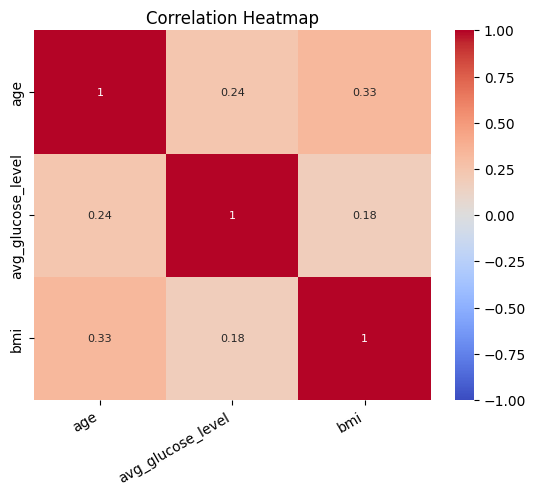

In [20]:
#Examine the correlation among numeric features
heatmap=sns.heatmap(df[numerical_columns].corr(), annot=True, annot_kws={"size": 8},vmin=-1, vmax=1, cmap=sns.color_palette('coolwarm', as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30, ha='right')

**Age vs. BMI:** These 2 variables have a moderate positive correlation of 0.33, suggeting that as age increases, BMI tends to increase as well.<br>
**Age vs. Average Glucose Level** These 2 variables have a weaker positive correlation of 0.24, indicating a less strong relationship.<br>
**Average Glucose Level vs. BMI:** These variables have the weakest positive correlation of 0.18, suggresting very weak relationship.<br>

These correlations do not imply causation, but simply indicate the degree to which these variables move in relation to each others.

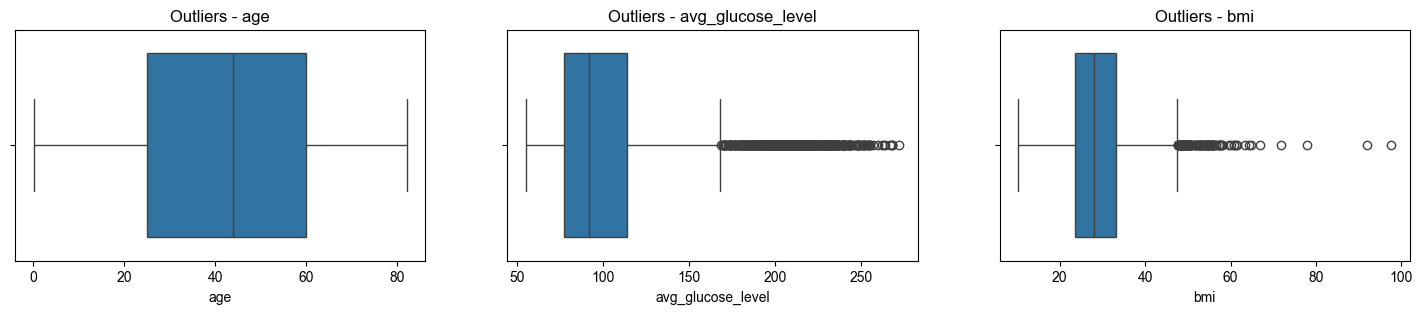

In [21]:
# Examine for any outliers in the variables: Age, Average Glucose Level, and BMI
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(18, 3))

sns.set(style='dark')

for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f'Outliers - {column}')

plt.show()

In [22]:
#Calculate the count and proportion of outliers for each variable.
outlier_cols = ['avg_glucose_level', 'bmi']

for col in outlier_cols:
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)

    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5*iqr
    lower_limit = percentile25 - 1.5*iqr
    outliers = df[(df[col]>upper_limit) | (df[col]<lower_limit)]
    print(f'{col}: {len(outliers)} rows, {(len(outliers)/df.shape[0])*100:.2f}% of total data.')

    #replace outliers with upper and lower limit
    df[col] = df[col].apply(lambda x: upper_limit if x> upper_limit else(lower_limit if x< lower_limit else x))

avg_glucose_level: 567 rows, 11.55% of total data.
bmi: 110 rows, 2.24% of total data.


<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=3>Categorical Variables (Distribution & Correlations)</h1>
</div>

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


In [24]:
#Retrieve the names of the categorical columns.
cat_columns = [col for col in df.columns if ((df[col].dtypes=='object') or (df[col].dtypes=='int64'))][:-1]
cat_columns

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'residence_type',
 'smoking_status']

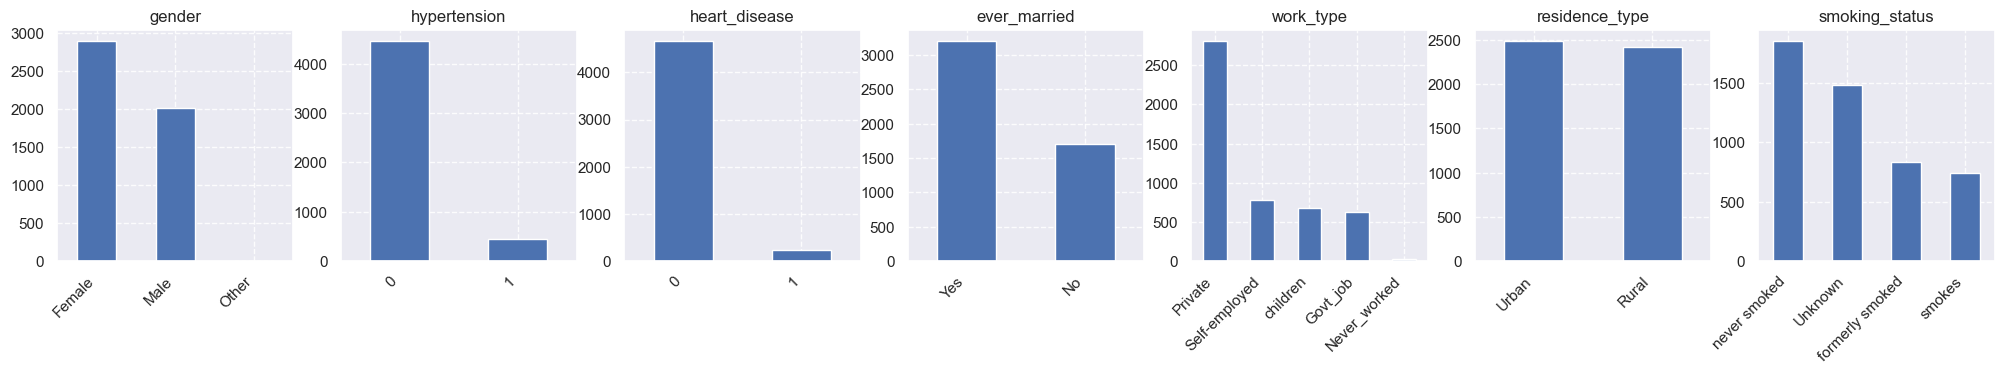

In [25]:
#Review the distribution of values for each categorical variable.
fig, axes = plt.subplots(1, len(cat_columns), figsize = (25, 3))
for i, col in enumerate(cat_columns):
    df[col].value_counts().plot(kind = 'bar', ax = axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45, ha = 'right')
    axes[i].set_title(col)
    axes[i].grid(True, linestyle = '--', alpha = 0.9)
    axes[i].set_xlabel('')
plt.show()

<b><u>Distribution</u></b><br>
**Gender:** The 1st subplot show that there are more females than males in this dataset, with a negligible count for other genders.<br>

**Hypertension & Heart Disease:** In both subplots, a significant number of individuals do not have these conditions, while a smallers portion does.<br>

**Ever-Married Status:** A majority of the population has been married.<br>

**Work Type:** Most people are in private employment, followed by self-employed and children. There are fewer people in government jobs and those who have never worked.<br>

**Residence Type:** The population is almost equally distributed between urban and rural areas.<br>

**Smoking Status:** A large number of individuals have never smoked, followed by unknown smoking status. There are fewer former smokers and current smokers.

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=4>Target Variable (Stroke)</h1>
</div>

The objective of this project is to predict the occurrence of ‘Stroke’, which is the target variable.

In [26]:
target = pd.DataFrame(df['stroke'].value_counts().reset_index())
target['%'] = (round(target['count']/df['stroke'].count(),5))*100
target

,stroke,count,%
0,0,4700,95.743
1,1,209,4.257


<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=5>Correlations Between Numerical Variables & Target</h1>
</div>

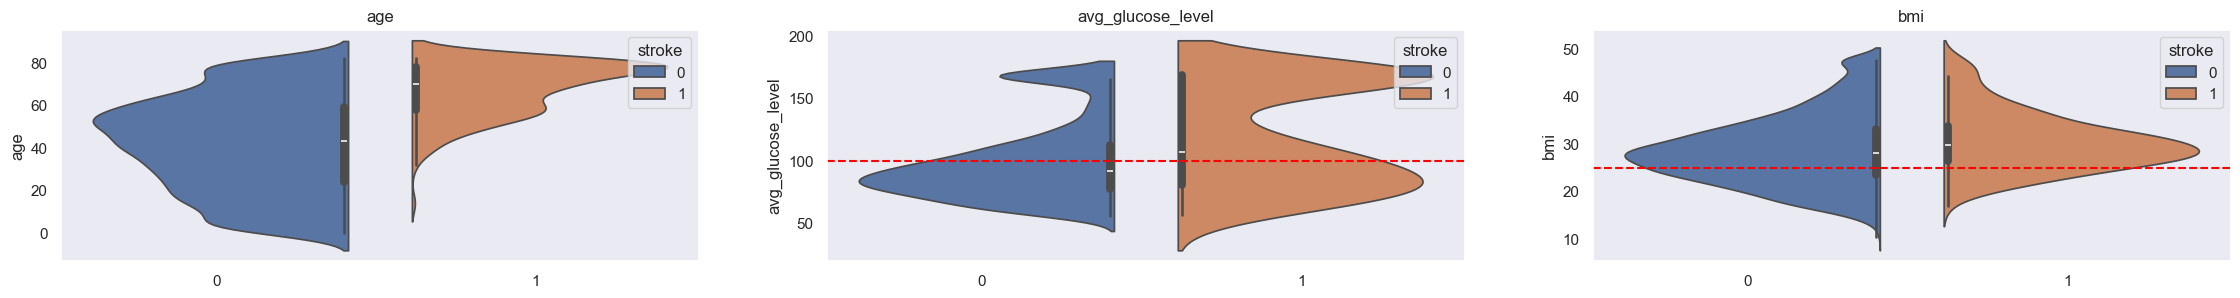

In [27]:
fig, axes = plt.subplots(1, len(numerical_columns), figsize=(28, 3))

for i, col in enumerate(numerical_columns):
    sns.violinplot(data=df, x='stroke', y=col, split=True, ax=axes[i], hue = 'stroke')
    
    if col == 'avg_glucose_level':
        axes[i].axhline(y = 100, color = 'red', linestyle = '--', label = 'healthy')
    if col == 'bmi':
        axes[i].axhline(y = 24.9, color = 'red', linestyle = '--', label = 'healthy')
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0, ha='right')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
plt.show()

**Age vs. Stroke:** There is a clear distinction in age distribution between individuals who have had a stroke and those eho haven't. Older individuals are more prone to strokes, as indicated by the notable amount of orange at higher ages.<br>

**Average Glucose Level vs. Stroke:** Higher glucose levels (>100) are associated with higher incidences of strokes. This is suggested by the apparent increase in organge coloration at higher glucose levels.<br>

**BMI vs. Stroke:** The BMI distribution does not show a significant difference between the two groups, implying that BMI might not be as indicative of stroke as age or average glucose level.<br>

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=6>Correlations Between Categorical Variables & Target</h1>
</div>

In [28]:
cat_columns

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'residence_type',
 'smoking_status']

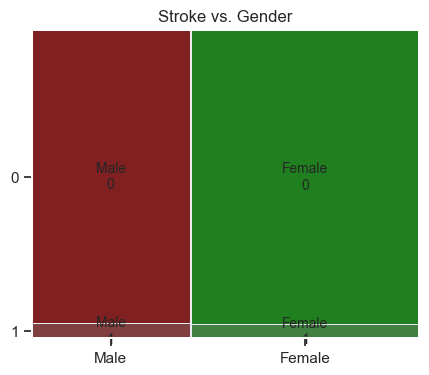

In [29]:
filtered_df = df[df['gender'] != 'Other']
fig, ax = plt.subplots(figsize=(5,4))
mosaic(filtered_df, ['gender', 'stroke'], title='Stroke vs. Gender', ax = ax)
plt.show()

**Stroke vs. Age:** The ratio of stroke occurrence to non-occurence does not show a noticeable difference between males and females.<br>

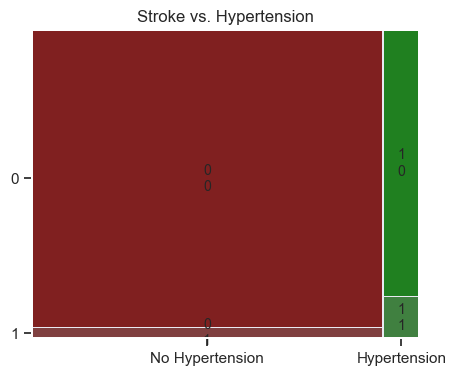

In [30]:
fig, ax = plt.subplots(figsize=(5,4))
mosaic(df, ['hypertension', 'stroke'], title='Stroke vs. Hypertension', ax = ax)
ax.set_xticklabels(['No Hypertension', 'Hypertension'])
plt.show()

**Stroke vs. Hypertension:** The proportion of having experienced a stroke is higher among people with hypertension compared to those without.<br>

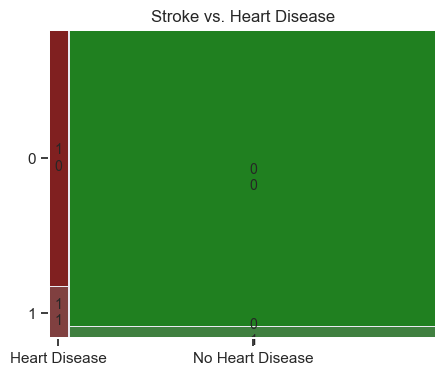

In [31]:
fig, ax = plt.subplots(figsize=(5,4))
mosaic(df, ['heart_disease', 'stroke'], title='Stroke vs. Heart Disease', ax = ax)
ax.set_xticklabels(['Heart Disease', 'No Heart Disease'])
plt.show()

**Stroke vs. Heart Disease:** The percentage of individuals who have experienced a stroke is higher among those with heart disease compared to those without.

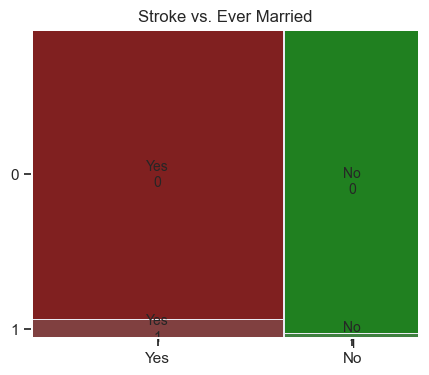

In [32]:
fig, ax = plt.subplots(figsize=(5,4))
mosaic(df, ['ever_married', 'stroke'], title='Stroke vs. Ever Married', ax = ax)
plt.show()

**Stroke vs. Ever Married:** The percentage of individuals who have experienced a stroke is higher among those who have been married compared to those who have never married.

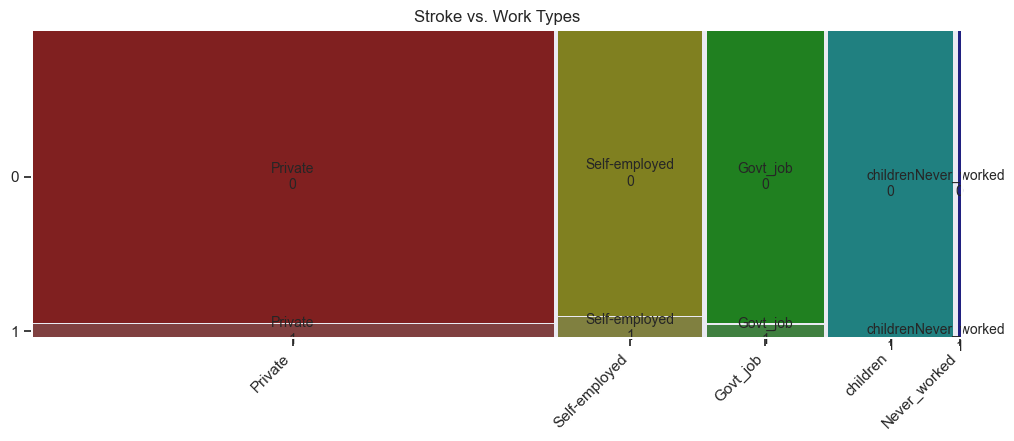

In [33]:
fig, ax = plt.subplots(figsize=(12,4))
mosaic(df, ['work_type', 'stroke'], title='Stroke vs. Work Types', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

**Stroke vs. Work Type:** Among all employment types, self-employed individuals exhibit the highest proportion of strokes.

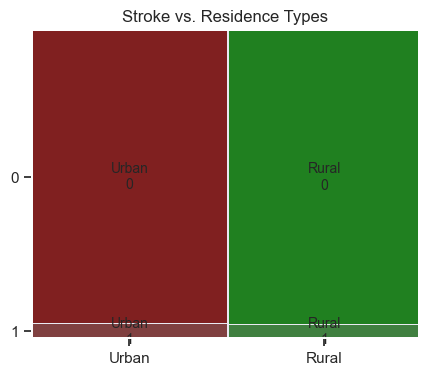

In [34]:
fig, ax = plt.subplots(figsize=(5,4))
mosaic(df, ['residence_type', 'stroke'], title='Stroke vs. Residence Types', ax = ax)
plt.show()

**Stroke vs. Residence Type:** There is no significant difference in the correlation with having a stroke between urban and rural areas.

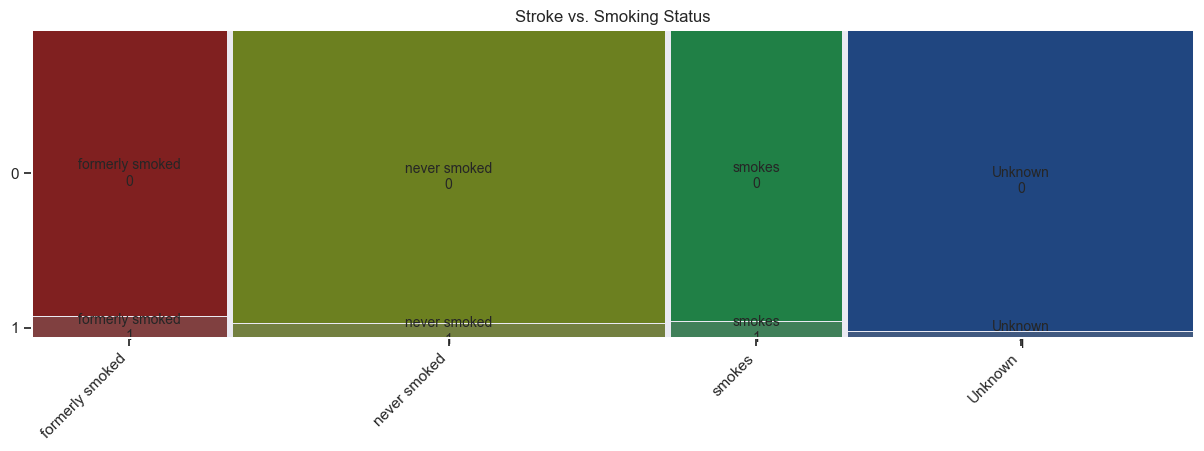

In [35]:
fig, ax = plt.subplots(figsize=(15,4))
mosaic(df, ['smoking_status', 'stroke'], title='Stroke vs. Smoking Status', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

**Stroke vs. Smoking Status:** Former and current smokers have the highest proportions of experiencing a stroke.

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=7>Preprocessing</h1>
</div>

Preprocesing in machine learning involves the preparation and transformation of raw data before it is fed into a model for training. This is an esssential step that aims to enhance the quality of data, mitigate noise, and address inconsistencies.<br>

The preprocessing section in this project includes encoding, resampling, splitting, and scaling the data. Preprocessing contributes to improved model performance, faster training times, and more accurate predictions.

Preprocessing 1 - Encoding the categorical data

In [36]:
#Create a copy of the original dataset
df_enc = df.copy()

#Encode the categorical columns
df_enc = pd.get_dummies(df_enc, drop_first = False)
df_enc.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,168.32,36.6,1,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False
2,80.0,0,1,105.92,32.5,1,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False
3,49.0,0,0,168.32,34.4,1,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True
4,79.0,1,0,168.32,24.0,1,True,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False
5,81.0,0,0,168.32,29.0,1,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False


Preprocessing 2 - Class Imbalance and Resampling<br>

Class imbalance is a common challenge in machine learning where the distribution of target classes ("Stroke (1 or 0) in this dataset) is uneven, with one class significantly outnumbering the others. This imbalance can lead to biased models that perform poorly on minority classes. To address this issues, resampling  techniques are used. 

In [37]:
print(f'Once again, this dataset contains {df_enc.shape[0]} rows.')

Once again, this dataset contains 4909 rows.


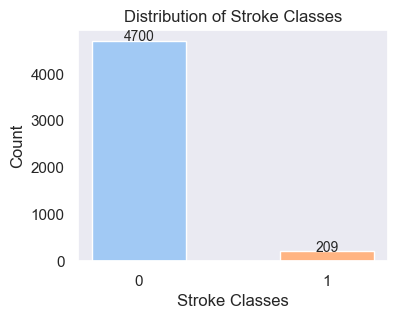

In [38]:
data_balance_check = df_enc['stroke'].value_counts().reset_index()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4,3))
colors = sns.color_palette('pastel')
plt.bar(x='stroke', height='count', data=data_balance_check, color=colors, width = 0.5)
plt.title('Distribution of Stroke Classes')
plt.xlabel('Stroke Classes')
plt.ylabel('Count')
plt.xticks(ticks = range(len(data_balance_check)))

for bar in ax.patches:
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    ax.text(x, y, str(bar.get_height()), ha = 'center', fontsize = 10)
plt.show()

The dataset is strongly imbalanced. There are 4700 patients with target = 0 (no stroke), but only 209 (<5%) cases with target = 1. This imbalance could arise from various factors such as data collection biases, or natural occurrences in real-world scenarios, etc.

In [39]:
#Upsampling the minorty (stroke = 1) by duplicating additionally samples with replacement until the number of samples in the minority class matches the number of samples in the majority class.
majority = df_enc[df_enc['stroke']==0]
minority = df_enc[df_enc['stroke']==1]

minority_upsampled = resample(minority,
                              replace = True,
                              n_samples = len(majority),
                              random_state=RANDOM_STATE)

df_enc = pd.concat([majority, minority_upsampled])

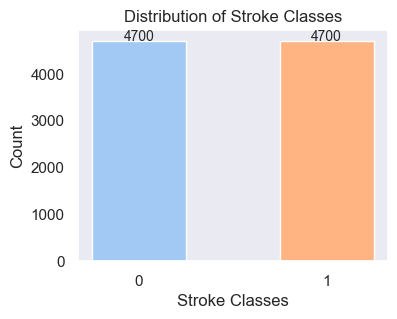

In [40]:
data_balance_check = df_enc['stroke'].value_counts().reset_index()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4,3))
colors = sns.color_palette('pastel')
plt.bar(x='stroke', height='count', data=data_balance_check, color=colors, width = 0.5)
plt.title('Distribution of Stroke Classes')
plt.xlabel('Stroke Classes')
plt.ylabel('Count')
plt.xticks(ticks = range(len(data_balance_check)))

for bar in ax.patches:
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    ax.text(x, y, str(bar.get_height()), ha = 'center', fontsize = 10)
plt.show()

In [41]:
print(f'This dataset now contains {df_enc.shape[0]} rows.')

This dataset now contains 9400 rows.


Preprocessing 3 - Splitting the dataset

In [42]:
X = df_enc.drop('stroke', axis = 1)
y = df_enc['stroke']

In [43]:
#keep 60% of the dataset for training
X_train, X_, y_train, y_ = train_test_split(X, y, test_size = 0.40, random_state = RANDOM_STATE)

#further split the 40% into validation (20%) and test(20%)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size = 0.50, random_state=RANDOM_STATE)

In [44]:
X_train.shape

(5640, 21)

In [45]:
y_train.shape

(5640,)

Preprocessing 4 - Scaling the data<br>

Data scaling involves transforming the numerical features to a consistent scale, in this case, -1 to 1.

In [46]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=8>Model Approach 1 - Logistic Regression</h1>
</div>

In [47]:
#Instantiate and train the model.
log_clf = LogisticRegression(random_state=RANDOM_STATE, max_iter = 100).fit(X_train, y_train)

In [48]:
#Make prediction on the validation set we just reserved above
y_val_pred= log_clf.predict(X_val)

In [49]:
for pred, true_val in zip(y_val_pred[:10], y_val[:10]):
    print(f'Prediction: {pred}, True Label: {true_val}')

Prediction: 1, True Label: 0
Prediction: 0, True Label: 0
Prediction: 1, True Label: 1
Prediction: 1, True Label: 1
Prediction: 1, True Label: 0
Prediction: 1, True Label: 0
Prediction: 1, True Label: 1
Prediction: 0, True Label: 0
Prediction: 0, True Label: 0
Prediction: 1, True Label: 0


In [50]:
#Define a function that creates confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels = classes)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.rcParams['figure.figsize'] = (4, 4)
    cm_display.plot()
    plt.show()

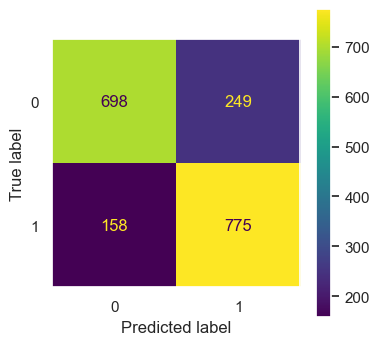

In [51]:
#Call the function
plot_confusion_matrix(y_val, y_val_pred, log_clf.classes_)

In [52]:
#Define a function to retrieve the performance metrics
def compute_metrics(model_name, y_test, y_pred):
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score,
        'ROC-AUC': roc_auc_score
    }

    metrics_dict = {'Model': model_name}
    for metric_name, metric_func in metrics.items():
        metric_value = metric_func(y_test, y_pred)
        metrics_dict[metric_name] = metric_value
    return pd.DataFrame([metrics_dict])

In [53]:
#Use the function to retrieve performance metrics of Model 1
score_log_reg = compute_metrics('Logistic Regression', y_val, y_val_pred)
score_log_reg

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.783511,0.756836,0.830654,0.792029,0.783859


**Accuracy:**  Accuracy score is calculated by dividing number of correct predictions by the total number of predictions.<br>

**Precision:**  Precision is the ratio of true positive predictions to the total number of positive predictions (true positives + false positives). It measures the accuracy of the positive predictions made by the model and is sensitive to false positives. Prediction = TP/(TP + FP)<br>

**Recall:** Recall is the ratio of true positive predictions to the total number of actual positives (true positives + false negatives). It measures the ability of the model to capture all positive instances and is sensitive to false negatives.Recall = TP/(TP+FN)<br>

**About Precision - Recall Trade-off:**
The tradeoff between precision and recall arises because, in many cases, improving one metric may lead to a deterioration in the other. For example, increasing the threshold for positive predictions tends to increase precision but decrease recall, and vice versa.<br>

**F1 Score:** F1 Score is the harmonic means of Precision and Recall. A high F1 score symbolizes a high precision as well as a high recall, which presents a good balance between the two.<br>

**ROC-AUC:** `roc_auc` stands for `Area Under the Receiver Operating Characteristic Curve`. The ROC graph summarizes all of the confusion matrices that each threshold produced and the ROC-AUC score is the area under it.<br>

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=9>Model Approach 2 - Decision Tree</h1>
</div>

In [54]:
#Instantiate a decision tree model. Use a grid search for hyperparameter tuning.
tree_model = DecisionTreeClassifier(random_state = RANDOM_STATE)
cv_params = {'min_samples_leaf':[1, 2, 3, 4, 5, 10],
             'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10, None],
             'min_samples_split':[2, 3, 4, 5, 6, 7, 10, 15, 20]}
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tree1 = GridSearchCV(tree_model, cv_params, scoring = scoring, cv=4, refit='roc_auc')

In [55]:
%%time
tree1.fit(X_train, y_train)

CPU times: user 16.2 s, sys: 106 ms, total: 16.3 s
Wall time: 16.3 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 10, 15, 20]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [56]:
print(tree1.best_params_)
print(tree1.best_score_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.9651706719273075


**'max_depth': None:** The indicates that the decision tree was allowed to grow without any restriction on the depth.

**'min_samples_leaf': 1** A value of 1 means that each leaf node in the decision tree contains only 1 sample. 

**'min_samples_split': 2** With a value of 2, the decision tree splits a node if it contains at least 2 samples. 

The best score achieved by this model is approximately `roc_auc = 0.965`, which suggests that it performs well in predicting the target variable.

In [57]:
y_val_pred = tree1.predict(X_val)

In [58]:
for pred, true_val in zip(y_val_pred[:10], y_val[:10]):
    print(f'Prediction: {pred}, True Label: {true_val}')

Prediction: 0, True Label: 0
Prediction: 0, True Label: 0
Prediction: 1, True Label: 1
Prediction: 1, True Label: 1
Prediction: 1, True Label: 0
Prediction: 1, True Label: 0
Prediction: 1, True Label: 1
Prediction: 0, True Label: 0
Prediction: 0, True Label: 0
Prediction: 0, True Label: 0


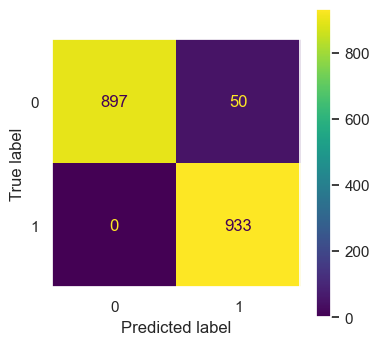

In [59]:
plot_confusion_matrix(y_val, y_val_pred, tree1.classes_)

In [60]:
score_decision_tree = compute_metrics('Decision Tree', y_val, y_val_pred)
score_decision_tree

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Decision Tree,0.973404,0.949135,1.0,0.973904,0.973601


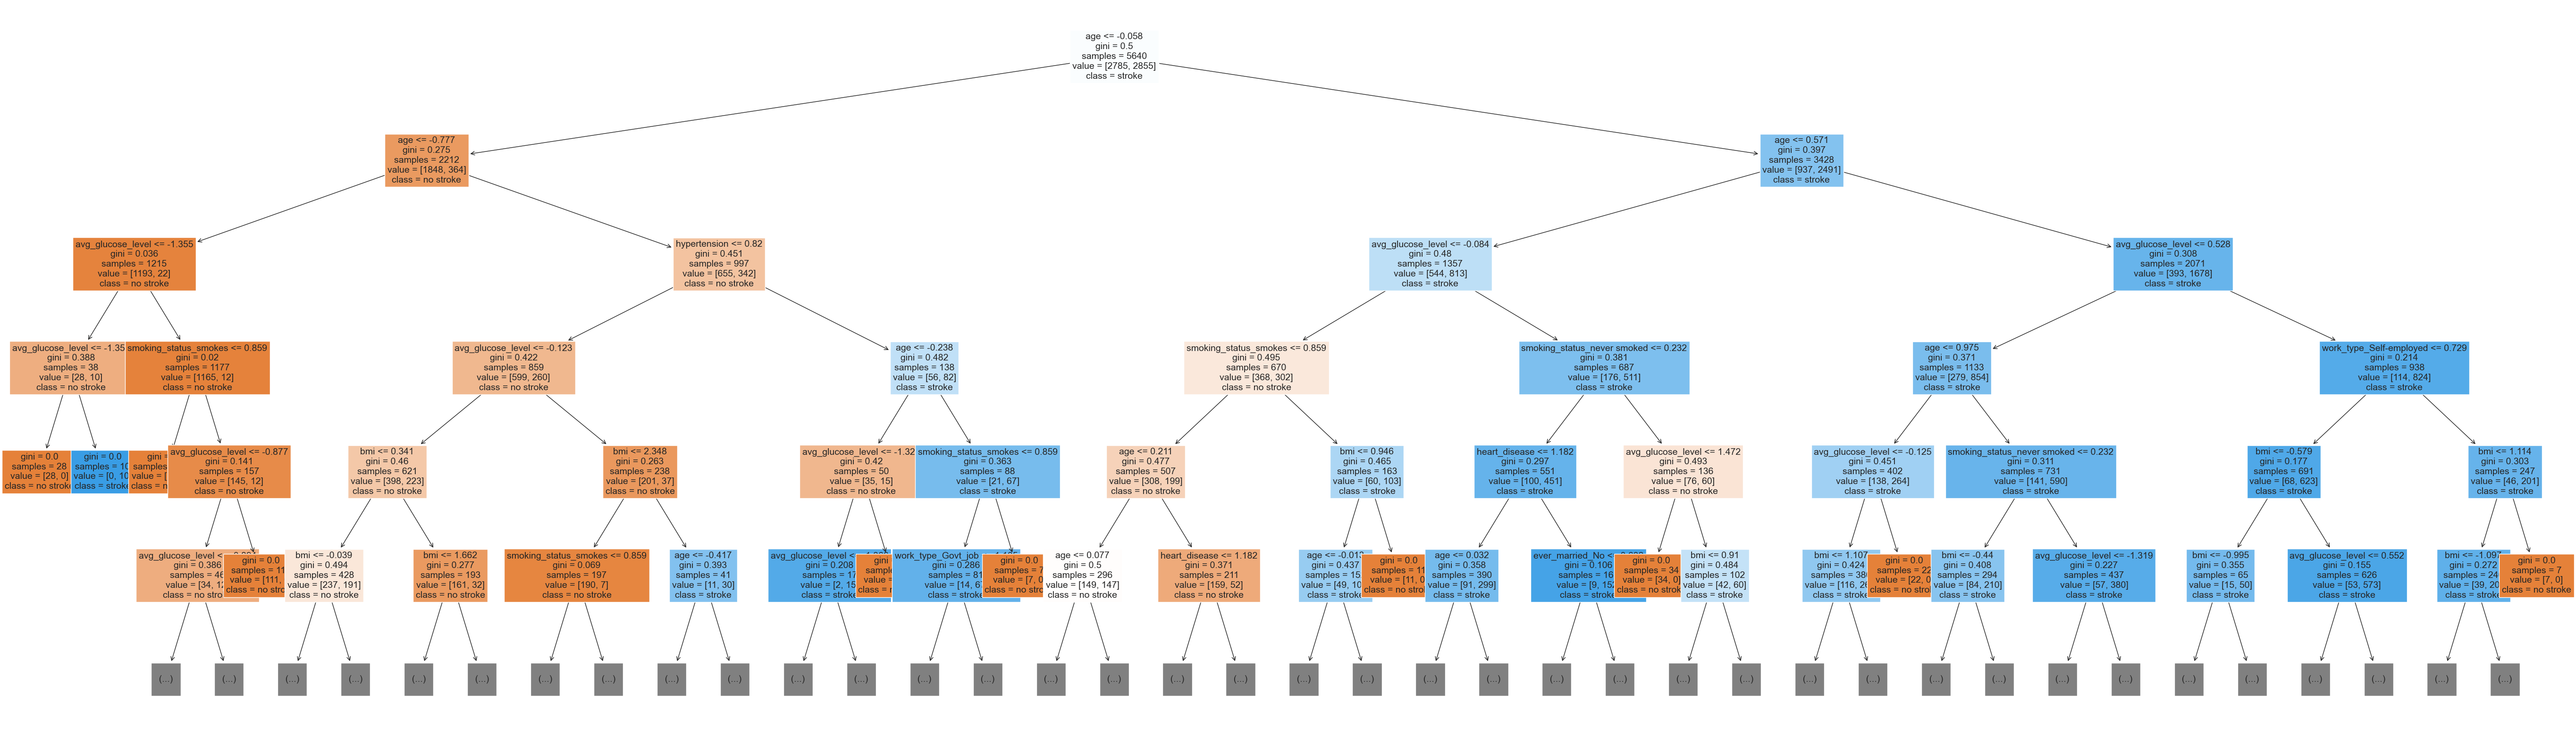

In [61]:
#Plot the top 5 levels of the decisiion tree
plt.figure(figsize = (70, 20))
plot_tree(tree1.best_estimator_, 
          max_depth = 5, 
          fontsize = 14, 
          feature_names = X.columns, 
          class_names = {0: 'no stroke', 1:"stroke"}, 
          filled = True )
plt.show()

Decision Tree feature importance

In [62]:
tree1_importance = pd.DataFrame(tree1.best_estimator_.feature_importances_, 
                                columns = ['gini_importance'],
                                index = X.columns)

tree1_importance = tree1_importance.sort_values(by = 'gini_importance', ascending = False)

#Only extract the features with importances > 0

tree1_importance = tree1_importance[tree1_importance['gini_importance']!= 0]
tree1_importance

,gini_importance
age,0.472885
bmi,0.206841
avg_glucose_level,0.175951
smoking_status_never smoked,0.024536
heart_disease,0.015610
work_type_Self-employed,0.014981
smoking_status_formerly smoked,0.013494
smoking_status_smokes,0.012613
gender_Male,0.011557
hypertension,0.010862


`Gini importance` is a measure of the contribution of each feature to the overall `Gini Impurity` reduction in this model.  Higher Gini importance values indicate that a feature plays a more significant role in making decisions and splitting the data.

In our model, `Age` has the highest Gini importance, suggesting that it is the most influential feature in predicting the target variable. The decision tree relies heavily on age for making splits.

<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=10>Model Approach 3 - Random Forest</h1>
</div>

Random Forest consists of a collection of decision trees, where each tree is trained on a random subset of the dataset.

In [63]:
# rf = RandomForestClassifier(random_state=RANDOM_STATE)
# cv_params = {'max_depth': [2, 3, 4, 5, None], 
#              'max_features': [1.0],
#              'max_samples': [0.5, 0.7, 1.0],
#              'min_samples_leaf': [1, 2, 3],
#              'min_samples_split': [2, 3, 4],
#              'n_estimators': [300, 500],
#              }
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
# rf1 = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit = 'f1')

In [64]:
# %%time
# rf1.fit(X_train, y_train)

Define a function to pickle the model for future use.

In [65]:
path = 'Stroke Prediction'

def write_pickle(path, model, save_as:str):
    with open(path + save_as + '.pickle','wb') as to_write:
        pickle.dump(model, to_write)

In [66]:
def read_pickle(path, saved_model:str):
    with open(path + saved_model + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
    return model

Use the function above to pickle the rf1 model that took 16 min to run.

In [67]:
# write_pickle(path, rf1, 'rf1')

In [68]:
rf1 = read_pickle(path, 'rf1')

In [69]:
print(rf1.best_params_)
print(rf1.best_score_)

{'max_depth': None, 'max_features': 1.0, 'max_samples': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}
0.9735865396370925


In [70]:
y_val_pred = rf1.predict(X_val)

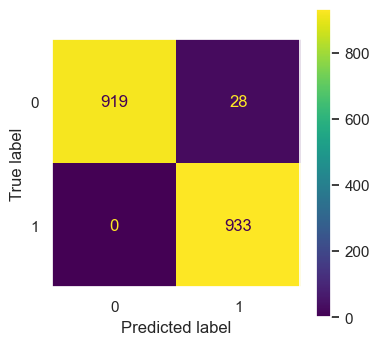

In [71]:
plot_confusion_matrix(y_val, y_val_pred, rf1.classes_)

In [72]:
score_random_forest = compute_metrics('Random Forest', y_val, y_val_pred)
score_random_forest

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Random Forest,0.985106,0.970864,1.0,0.985216,0.985216


In [73]:
rf1_importance = pd.DataFrame(rf1.best_estimator_.feature_importances_, 
                                columns = ['gini_importance'],
                                index = X.columns)

rf1_importance = rf1_importance.sort_values(by = 'gini_importance', ascending = False)

#Only extract the features with importances > 0

rf1_importance = rf1_importance[rf1_importance['gini_importance']!= 0]
rf1_importance

,gini_importance
age,0.465623
avg_glucose_level,0.184179
bmi,0.179536
smoking_status_never smoked,0.023471
hypertension,0.017437
work_type_Self-employed,0.015445
smoking_status_smokes,0.013021
smoking_status_formerly smoked,0.011390
heart_disease,0.011361
smoking_status_Unknown,0.010684


<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id=11>Model Approach 4 - XGBoost</h1>
</div>

XGBoost (eXtreme Gradient Boosting) builds an ensemble of decision trees sequentially, with each tree correcting the errors of its predecessors.

In [74]:
#Converting dfs into DMatrix as XGBoost comes with its own class for storing datasets.
dtrain_cls = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval_cls = xgb.DMatrix(X_val, label=y_val, enable_categorical = True)
dtest_cls = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [75]:
params = {
    "objective": "binary:logistic",
}

n = 10000
evals = [(dtrain_cls, 'train'), (dval_cls, 'validation')]
xgb = xgb.train(
    params=params,
    dtrain=dtrain_cls,
    num_boost_round=n,
    evals = evals,
    verbose_eval = 10,
    early_stopping_rounds = 50
)

[0]	train-logloss:0.54998	validation-logloss:0.55712
[10]	train-logloss:0.25955	validation-logloss:0.28451
[20]	train-logloss:0.18470	validation-logloss:0.22058
[30]	train-logloss:0.13423	validation-logloss:0.18028
[40]	train-logloss:0.09643	validation-logloss:0.14673
[50]	train-logloss:0.07660	validation-logloss:0.12828
[60]	train-logloss:0.06354	validation-logloss:0.11758
[70]	train-logloss:0.05158	validation-logloss:0.10834
[80]	train-logloss:0.04231	validation-logloss:0.09927
[90]	train-logloss:0.03457	validation-logloss:0.09152
[100]	train-logloss:0.02917	validation-logloss:0.08578
[110]	train-logloss:0.02469	validation-logloss:0.08367
[120]	train-logloss:0.02247	validation-logloss:0.08167
[130]	train-logloss:0.01987	validation-logloss:0.07856
[140]	train-logloss:0.01732	validation-logloss:0.07711
[150]	train-logloss:0.01558	validation-logloss:0.07540
[160]	train-logloss:0.01406	validation-logloss:0.07424
[170]	train-logloss:0.01316	validation-logloss:0.07424
[180]	train-logloss:0

We can see the model's performance on both our training and validation sets. It is normal that the training loss is lower than validation since the model has already seen the former.

Log loss (logarithm loss) measures the performance of a binary classification model, where the prediction input is a probability value between 0 and 1. The goal of our machine learning model is to minimize this value. A perfect model would have a log loss of 0. The value of log loss can be anything from 0 to infinity. Log loss increases as the predicted probability diverges from the actual label.

In [76]:
y_val_pred = xgb.predict(dval_cls)

y_pred contains probablities rather than discrete binary class labels. Convert probablities to binary predictions.

In [77]:
threshold = 0.5
y_val_pred = (y_val_pred >=threshold).astype(int)

In [78]:
#print the first 10 predictions and 10 actual values
for pred, true_val in zip(y_val_pred[:10], y_val[:10]):
    print(f'Prediction: {pred}, True Label: {true_val}')

Prediction: 0, True Label: 0
Prediction: 0, True Label: 0
Prediction: 1, True Label: 1
Prediction: 1, True Label: 1
Prediction: 0, True Label: 0
Prediction: 1, True Label: 0
Prediction: 1, True Label: 1
Prediction: 0, True Label: 0
Prediction: 0, True Label: 0
Prediction: 0, True Label: 0


In [79]:
#Get the metric scores using the function defined earlier
score_xgb = compute_metrics('XGBoost', y_val, y_val_pred)
score_xgb

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,XGBoost,0.973936,0.950102,1.0,0.974413,0.974129


<div style="background-color: #EAEAEA; padding: 0px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="text-align: center; color: #333333; font-size: 20px; font-weight: bold;", id = 12>Performance Comparison</h1>
</div>

Combine the metrics from all four models into one dataframe for easy comparison.

In [80]:
all_scores = pd.concat([score_log_reg,
                        score_decision_tree,
                        score_random_forest,
                        score_xgb])
all_scores

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.783511,0.756836,0.830654,0.792029,0.783859
0,Decision Tree,0.973404,0.949135,1.000000,0.973904,0.973601
0,Random Forest,0.985106,0.970864,1.000000,0.985216,0.985216
0,XGBoost,0.973936,0.950102,1.000000,0.974413,0.974129


Visualize all metrics of all 4 models in 1 graph

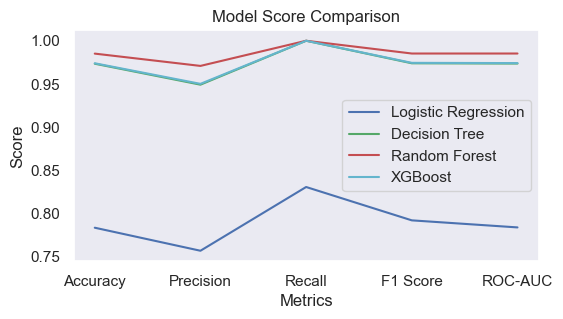

In [81]:
metrics = all_scores.columns.tolist()[1:]
colors = ['b', 'g', 'r', 'c']
plt.figure(figsize=(6,3))
x = np.arange(len(metrics))

for i, model in enumerate(all_scores['Model']):
    plt.plot(x, all_scores.loc[all_scores['Model'] == model, metrics].values[0], color=colors[i], label=model)

plt.xticks(x, metrics)
plt.legend()
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Score Comparison')
plt.show()

According to the graph, Model Approach 3 - Random Forest is the best-performing model. Use Random Forest for final testing.

In [82]:
y_pred_final = rf1.predict(X_test)
final_score = compute_metrics('Final Test Score', y_test, y_pred_final)
final_score

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Final Test Score,0.977128,0.954974,1.0,0.976968,0.977789


Compare the final performance on the test set with the performance on the validation set.

In [83]:
comparison_df = pd.concat([score_random_forest, final_score])
comparison_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Random Forest,0.985106,0.970864,1.0,0.985216,0.985216
0,Final Test Score,0.977128,0.954974,1.0,0.976968,0.977789


In [84]:
comparison_df.columns.tolist()[1:]

['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

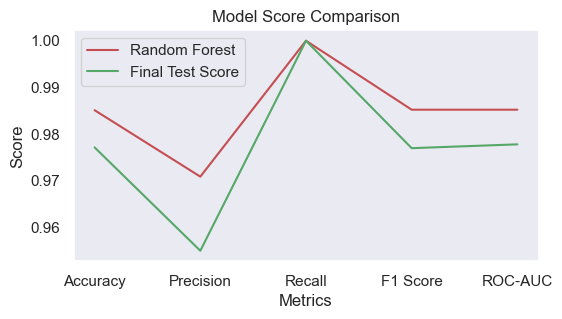

In [85]:
metrics = comparison_df.columns.tolist()[1:]
colors = ['r', 'g']
plt.figure(figsize=(6,3))
x = np.arange(len(metrics))

for i, model in enumerate(comparison_df['Model']):
    plt.plot(x, comparison_df.loc[comparison_df['Model'] == model, metrics].values[0], color=colors[i], label=model)

plt.xticks(x, metrics)
plt.legend()
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Score Comparison')
plt.show()